In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import MetaTrader5 as mt5
import datetime as dt
import ta
import pytz
from statsmodels.regression.rolling import RollingOLS
import numpy as np
from scipy.optimize import minimize
import pickle
from sklearn.cluster import KMeans
timezone = pytz.timezone("Etc/UTC")
timezone
today = dt.datetime.now()

c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def padrao(df):
    df.rename(columns={'time':'Date', 'open':'Open', 'high':'High','low':'Low','close':'Close'}, inplace=True)
    df.drop(['tick_volume','spread','real_volume'], axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    return df

def retorno(df):
    df['Retorno'] = df['Close'].pct_change()
    
    df.dropna(inplace=True)
    return df

In [3]:
def var(df):
    

    


    df['RSL5'] = (df['Close']/df['Close'].rolling(5).mean())-1
    df['RSL5q'] = pd.qcut(df['RSL5'], q=7, labels=False)
    df['RSL20'] = (df['Close']/df['Close'].rolling(20).mean())-1

    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_cat'] = pd.qcut(df['rsi'], 7,labels=False)

    df['filtro'] = np.where(df["RSL5"] < df["RSL20"], 1, -1) 
    df['media_movel'] = df['Close'].rolling(200).mean()
    df['media_movel2'] = df['Close'].rolling(5).mean()
    h = df['media_movel2'] / df['media_movel']
    l = 3 
    df['tan200'] = h/l
    df['ang200'] = np.degrees(df['tan200'])
    df['ang_cat'] = pd.qcut(df['ang200'], q=5, labels=False)

    df['sinal'] = np.where((df['filtro']==-1)& ((df['ang_cat'] ==0) | df['ang_cat'] ==2), -1,
                            np.where((df['filtro']==1)& ((df['ang_cat'] ==5) | df['ang_cat'] ==3), 1, 0)) 

    df['rsi_sinal'] = np.where(df['rsi'] < 30, 1,
                          np.where(df['rsi'] > 70, -1, 0))


    df['rsi_cat_sinal'] = np.where((df['rsi_sinal'] == 1) & ((df['rsi_cat'] == 4)| (df['rsi_cat'] == 6)| (df['rsi_cat'] == 1)),1,
                            np.where((df['rsi_sinal'] == -1) & ((df['rsi_cat'] == 2)| (df['rsi_cat'] == 5)), -1, 0))


    df['desvio_padrao'] = df["Retorno"].rolling(window=15).std()
    df['media'] = df["Retorno"].rolling(window=15).mean()
    df['ajuste_media'] = df["Retorno"] - df['media']
    df['max_diff'] = df['ajuste_media'].rolling(window=15).max()
    df['min_diff'] = df['ajuste_media'].rolling(window=15).min()
    df['R/S'] = (df['max_diff'] - df['min_diff'])/df['desvio_padrao']
    df['hurst'] = (np.log2(df['R/S'].values))/np.log2(15)

    df['hurst_sinal'] = np.where(df['hurst'] > 0.5, 1, np.where(df['hurst'] < 0.45, -1, 0))

    df['std15'] = df['Close'].rolling(15).std()
    df['MA'] = df['Close'].rolling(5).mean()

    df["zscore"] = ((df["Close"]-df['Close'].rolling(5).mean())/df['Close'].rolling(10).std())
    std = (df['zscore'].std())*1.2
    df['zscore_sinal'] = np.where(df['zscore'] > std, -1, np.where(df['zscore'] < -std, 1, 0))


    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    #df['rsi'] = pd.qcut(df['rsi'], 5,labels=False)





    stochasticOscillator = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=15, smooth_window=3)
    df['stochasticOscillator'] = stochasticOscillator.stoch()
    df['stochasticOscillator'] = df['stochasticOscillator']/100
    #df['stochasticOscillator'] = pd.qcut(df['stochasticOscillator'], 5, labels=False)

    df['stochasticOscillator_sinal'] = np.where(df['stochasticOscillator'] <= 0.2, 1, np.where(df['stochasticOscillator'] < 0.8, -1, 0))



    #bandas de bollingerBand
    bollingerBand = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_bollinger_avg'] = bollingerBand.bollinger_mavg()
    df['bb_lband'] = bollingerBand.bollinger_lband()
    df['bb_hband'] = bollingerBand.bollinger_hband()
    df['sinal_bb'] = np.where(df['Close']>df['bb_hband'],-1, np.where(df['Close']<df['bb_lband'],1,0))


    
    h = df['Close'].shift(21) - df['Close']
    l = 21
    df['tan30'] = h/l
    df['ang30'] = np.arctan(df['tan30'])
    std = (df['ang30'].std())
    df['tan30_sinal'] = np.where(df['ang30'] > std, 1, np.where(df['ang30'] < -std, -1, 0))
    df['tan30_cat'] = pd.qcut(df['ang30'], q=4, labels=[1,2,3,4])




    stochRSI = ta.momentum.StochRSIIndicator(close=df['Close'], window=15, smooth1=3, smooth2=3)
    df['stochRSI'] = stochRSI.stochrsi()
    df['stochRSI_cat'] = pd.qcut(df['stochRSI'], 5, labels=False)

    df['stochRSI_sinal'] = np.where((df['tan30_cat'] == 1) & (df['stochRSI_cat'] == 0), 1,
                                np.where((df['tan30_cat'] == 2) & (df['stochRSI_cat'] == 4), -1, 0))



    vol_p1 = 20
    df['Vol'] = np.round(df['Retorno'].rolling(vol_p1).std()*np.sqrt(252), 4)

    df["Date"] = df.index
    df["WeekDay"] = df["Date"].dt.dayofweek #Monday is day 0


    WeeklyVol = df["Vol"]/np.sqrt(52)
    RefPrice = df["Close"]
    df["WeeklyVol"] = df["Vol"]/np.sqrt(52)
    df["RefPrice"] = df["Close"]

    for i in range(1,len(df)):
        if df["WeekDay"][i] == 0:
            df["WeeklyVol"][i] = WeeklyVol[i-1]
            df["RefPrice"][i] = RefPrice[i-1]
        else:
            df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
            df["RefPrice"][i] = df["RefPrice"][i-1]

    df["Supply_Band_1d"] = np.round(df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_1d"] = np.round(df["RefPrice"] - df["WeeklyVol"]*df["RefPrice"], 2)
    df["Supply_Band_2d"] = np.round(2*df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_2d"] = np.round(df["RefPrice"] - 2*df["WeeklyVol"]*df["RefPrice"], 2)


    df['macd_9'] = df['Retorno'].rolling(window=10).mean()
    df['macd_26'] = df['Retorno'].ewm(span=30, adjust=False).mean()
    df['disc_macs'] = (df['macd_9'] - df['macd_26'])-1
    df['disc_macs'] = pd.qcut(df['disc_macs'], 10, labels=False)

    df["dis_vol"] = df["Vol"]/df["WeeklyVol"]
    df["dis_vol_cat"] = pd.qcut(df["dis_vol"], 7, labels=False)

    df['Return20'] = df['Close'].pct_change(20)
    df['sum_returns']=df['Return20'].rolling(5).mean()
    df['return_cost'] = df['Return20']/df['sum_returns']
    df['return_cost_cat'] = pd.qcut(df['return_cost'], 7, labels=False)


    df['MA20'] = df['Close'].rolling(20).mean()
    #df['Return20'] = df['Return20'].shift(-20)
    df['STD_Returns'] = df['Return20'].rolling(20).std()
    df['RSL20'] = (df['Close']/df['MA20'])-1
    df['RSL'] = (df['Close']/df['Close'].rolling(10).mean())-1

    df['delta1'] = df['Close'].diff()
    df['gain1'] = np.where(df['delta1']>=0, df['delta1'], 0)
    df['loss1'] = np.where(df['delta1']<0, abs(df['delta1']), 0)
    avg_gain1 = df['gain1'].rolling(window=20).mean()
    avg_loss1 = df['loss1'].rolling(window=20).mean()
    rs1 = avg_gain1 / avg_loss1
    df['rsi1'] = 100 - (100 / (1 + rs1))




    last_friday_return = 0

    df["FRI_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_friday_return = row["Return20"]
        
        df.at[idx, "FRI_Returns"] = last_friday_return

    # Initialize a variable to store the last Friday STD_Returns
    last_STD_Returns = 0

    # Create a new column for the Friday STD_Returns in df1
    df["FRI_STD_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_STD_Returns = row["STD_Returns"]
        
        df.at[idx, "FRI_STD_Returns"] = last_STD_Returns


    # Initialize a variable to store the last Friday RSL
    last_RSL = 0

    # Create a new column for the Friday RSL in df1
    df["FRI_RSL"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_RSL = row["RSL20"]
        
        df.at[idx, "FRI_RSL"] = last_RSL

    last_rsi = 0
    df['FRI_rsi'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_rsi = row['rsi1']  # Substitua last_friday_rsi por last_rsi

        df.at[idx, "FRI_rsi"] = last_rsi

    df.dropna(axis = 0, inplace = True) 
    #Distância do cosseno
    # Initialize a list to store the results for each row
    COS_DIST = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST"] = COS_DIST
    df['COS_DIST_cat'] = pd.qcut(df['COS_DIST'], 7, labels=False)


    # Iterate over each row in the DataFrame

    COS_DIST2 = []
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST2.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST2"] = COS_DIST2
    df['COS_DIST2_cat'] = pd.qcut(df['COS_DIST2'], 7, labels=False)





    # Initialize a list to store the Euclidean distances for each row
    euclidean_distances = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST"] = euclidean_distances
    df['EUC_DIST_cat'] = pd.qcut(df['EUC_DIST'], 7, labels=False)

    euclidean_distances2 = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL",'FRI_rsi']].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL",'rsi1']].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances2.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST2"] = euclidean_distances2
    df['EUC_DIST2_cat'] = pd.qcut(df['EUC_DIST2'], 7, labels=False)


    df['curva_rsl'] = np.where(df['FRI_RSL'] == df['RSL20'], 0, 
                            np.where(df['FRI_RSL'] > df['RSL20'], 1, -1))

    df['curva_std'] = np.where(df['FRI_STD_Returns'] == df['STD_Returns'], 0, 
                            np.where(df['FRI_STD_Returns'] > df['STD_Returns'], 1, -1))


    df['dis_rsl'] = df['RSL20']/df['FRI_RSL']

    df['dis_std'] = df['STD_Returns']/df['FRI_STD_Returns']


    df['dis_euc_sinal'] = np.where(((g['EUC_DIST2_cat']== 0) & (g['EUC_DIST_cat']== 3)), 1,
                                np.where(((df['EUC_DIST_cat']== 5) | (df['EUC_DIST_cat']== 6)) & ((df['EUC_DIST2_cat']== 4) | (df['EUC_DIST2_cat']== 5)), -1, 0))

    df['dis_cos_sinal'] = np.where(((g['COS_DIST_cat']== 2) | (g['COS_DIST_cat']== 6)) & (g['COS_DIST2_cat']== 2), 1,
                                np.where(((df['COS_DIST_cat']== 1) | (df['COS_DIST_cat']== 4)) & ((df['COS_DIST2_cat']== 1) | (df['COS_DIST2_cat']== 0)), -1, 0))

    df['RSL20_cat'] = pd.qcut(df['RSL20'], 7, labels=False)


    df['Price_Lag'] = df['Close'].shift(1)
    df['Price_Lag2'] = df['Close'].shift(2)

    # Adicione a constante ao DataFrame
    df["const"] = 1

    # Ajuste o modelo de regressão com as novas colunas
    rolling_reg = RollingOLS(endog=df["Close"], exog=df[["const", "Price_Lag", "Price_Lag2"]], window=252)
    reg = rolling_reg.fit()

    # Extraia os coeficientes do modelo
    df['beta0'] = reg.params['const']
    df['beta1'] = reg.params['Price_Lag']
    df['beta2'] = reg.params['Price_Lag2']

    # Calcule a regressão
    df['reg'] = df['beta0'] + df['beta1'] * df['Price_Lag'] + df['beta2'] * df['Price_Lag2']
    df['detrend_reg'] = df['Close'] - df['reg']

    df['MM20'] = df['Close'].rolling(20).mean()

    df['index'] = np.arange(len(df))

    df['curva1_a'] = 1
    df['curva1_b'] = 1
    df['curva1_c'] = 1
    df['curva1_d'] = 1

    df['curva2_a'] = 1
    df['curva2_b'] = 2
    df['curva2_c'] = 1
    df['curva2_d'] = 1

    df['curva3_a'] = 1
    df['curva3_b'] = 3
    df['curva3_c'] = 1
    df['curva3_d'] = 1

    df['curva1'] = df['curva1_a'] * np.sin(df['curva1_b'] * df['index'] + df['curva1_c']) + df['curva1_d']
    df['curva2'] = df['curva2_a'] * np.sin(df['curva2_b'] * df['index'] + df['curva2_c']) + df['curva2_d']
    df['curva3'] = df['curva3_a'] * np.sin(df['curva3_b'] * df['index'] + df['curva3_c']) + df['curva3_d']


    df['curva_final'] = df['curva1'] + df['curva2'] + df['curva3']

    df['erro'] = df['detrend_reg'] - df['curva_final']



    # Função para calcular o erro total
    def erro_total(params, df):
        a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3 = params
        
        curva1 = a1 * np.sin(b1 * df['index'] + c1) + d1
        curva2 = a2 * np.sin(b2 * df['index'] + c2) + d2
        curva3 = a3 * np.sin(b3 * df['index'] + c3) + d3
        
        curva_final = curva1 + curva2 + curva3
        erro = df['detrend_reg'] - curva_final
        return np.sum(erro**2)

    # Estimativa inicial dos parâmetros
    initial_guess = [1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1]

    # Minimizar o erro para encontrar os melhores parâmetros
    result = minimize(erro_total, initial_guess, args=(df,), method='Nelder-Mead')

    # Extrair os melhores parâmetros encontrados
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3 = result.x
    print("Melhores parâmetros para a Curva 1:", a1, b1, c1, d1)
    print("Melhores parâmetros para a Curva 2:", a2, b2, c2, d2)
    print("Melhores parâmetros para a Curva 3:", a3, b3, c3, d3)

    # Calcular as curvas com os melhores parâmetros
    df['curva1_otimizada'] = (1.5505273509954591) * np.sin((0.8627974364633149) * df['index'] + (-0.5107090962968175)) + (5.067783992607492)
    df['curva2_otimizada'] = (0.4928078998565719) * np.sin((2.601774129153485) * df['index'] + (4.352681337119602)) + (-2.6978077541755248)
    df['curva3_otimizada'] = (-0.20773700559657748) * np.sin((4.116048600762351) * df['index'] + (-0.36911661308756893)) + (-2.223926882032824)

    # Calcular a curva final otimizada
    df['curva_final_otimizada'] = df['curva1_otimizada'] + df['curva2_otimizada'] + df['curva3_otimizada']

    #categorizar as curvas
    df['curva_final_cat'] = pd.qcut(df['curva_final_otimizada'], 15, labels=False)
    df['curva1_cat'] = pd.qcut(df['curva1_otimizada'], 15, labels=False)
    df['curva2_cat'] = pd.qcut(df['curva2_otimizada'], 15, labels=False)
    df['curva3_cat'] = pd.qcut(df['curva3_otimizada'], 15, labels=False)
    
    df.dropna(inplace=True)
    kmeans = KMeans(n_clusters = 20, random_state = 42).fit(df[['curva_final_otimizada','curva1_otimizada','curva2_otimizada','curva3_otimizada','detrend_reg']])
    df['cluster_curvas'] = kmeans.labels_
    #salvar o modelo

    filename = 'kmeans_curvas.sav'
    pickle.dump(kmeans, open(filename, 'wb'))

    
    last_curvaf = 0
    df['FRI_curva_final'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_curvaf = row['curva_final_otimizada']

        df.at[idx, "FRI_curva_final"] = last_curvaf

    last_curva1 = 0
    df['FRI_curva1'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_curva1 = row['curva1_otimizada']

        df.at[idx, "FRI_curva1"] = last_curva1

    last_curva2 = 0
    df['FRI_curva2'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_curva2 = row['curva2_otimizada']

        df.at[idx, "FRI_curva2"] = last_curva2

    last_curva3 = 0
    df['FRI_curva3'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_curva3 = row['curva3_otimizada']

        df.at[idx, "FRI_curva3"] = last_curva3

    last_hurst = 0
    df['FRI_hurst'] = None
    for idx, row in df.iterrows():
        if idx.weekday() == 4:
            last_hurst = row['hurst']

        df.at[idx, "FRI_hurst"] = last_hurst


    df.dropna(axis = 0, inplace = True) 


    COS_DIST3 = []
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[['FRI_hurst',"FRI_curva1","FRI_curva2","FRI_curva3","FRI_curva_final"]].to_numpy()
        array2 = row[['hurst','curva1_otimizada','curva2_otimizada','curva3_otimizada','curva_final_otimizada']].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST3.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST3"] = COS_DIST3
    df['COS_DIST3_cat'] = pd.qcut(df['COS_DIST3'], 5, labels=False)







    # Initialize a list to store the Euclidean distances for each row
    euclidean_distances = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row

        array1 = row[['FRI_hurst',"FRI_curva1","FRI_curva2","FRI_curva3","FRI_curva_final"]].to_numpy()
        array2 = row[['hurst','curva1_otimizada','curva2_otimizada','curva3_otimizada','curva_final_otimizada']].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST3"] = euclidean_distances
    df['EUC_DIST3_cat'] = pd.qcut(df['EUC_DIST3'], 5, labels=False)
        
    return df


In [4]:
ativos = ["XTIUSD"]
ativo = ativos[0]
mt5.initialize()

g = mt5.copy_rates_from(ativo, mt5.TIMEFRAME_D1, today, 4000)
g = pd.DataFrame(g)
g['time'] = pd.to_datetime(g['time'], unit='s')
padrao(g)
retorno(g)
var(g)
df = g.copy()



C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\2431245098.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df["WeekDay"][i] == 0:
C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\2431245098.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\2431245098.py:126: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas

Melhores parâmetros para a Curva 1: 0.37558086698720194 0.8375304698354527 1.3394281250592868 1.3903811752556803
Melhores parâmetros para a Curva 2: 0.9289068910038774 2.938862342680199 4.136982482189143 -0.7878763613687438
Melhores parâmetros para a Curva 3: -0.46511686588343826 3.970359248817939 0.0957813688687165 -0.5568342070177588


C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\2431245098.py:402: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['curva1_otimizada'] = (1.5505273509954591) * np.sin((0.8627974364633149) * df['index'] + (-0.5107090962968175)) + (5.067783992607492)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\2431245098.py:403: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['curva2_otimizada'] = (0.4928078998565719) * np.sin((2.601774129153485) * df['index'] + (4.352681337119602)) + (-2.6978077541755248)
C:\Users\camps pro\AppD

In [5]:
'''import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import classification_report, accuracy_score

df['lag1'] = df['Retorno'].shift(-1)
alvo = ['lag1']

df['lag1_bin'] = np.where(df['lag1'] > 0, 1, 0)
lista = [
 'curva1_cat','curva2_cat','curva3_cat','curva_final_cat',
 'COS_DIST3',
 'COS_DIST3_cat',
 'EUC_DIST3',
 'EUC_DIST3_cat']

start_train = "2010-01-01"
end_train = "2021-12-31"
df_filtrado = df.dropna()
# Vamos testar o modelo de 2011 à 2020
start_test = "2022-01-01"
end_test = "2024-04-08"

df_filtrado.dropna(inplace=True)

df_train = df_filtrado[start_train : end_train]

df_test = df_filtrado[start_test : end_test]

x_train = df_train[lista]
y_train = df_train[alvo]

x_test = df_test[lista]
y_test = df_test[alvo]


x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

lr_sm = sm.GLM(y_train, x_train).fit()

y_pred_train= lr_sm.predict(x_train)

y_pred_test = lr_sm.predict(x_test)

df_test['y_pred'] = y_pred_test
df_test['pred'] = np.where(df_test['y_pred'] > 0, 1, 0)
print(classification_report(df_test['lag1_bin'], df_test['pred']))
print(accuracy_score(df_test['lag1_bin'], df_test['pred']))
lr_sm.summary()'''

'import statsmodels.api as sm\nfrom statsmodels.formula.api import ols\nfrom sklearn.metrics import classification_report, accuracy_score\n\ndf[\'lag1\'] = df[\'Retorno\'].shift(-1)\nalvo = [\'lag1\']\n\ndf[\'lag1_bin\'] = np.where(df[\'lag1\'] > 0, 1, 0)\nlista = [\n \'curva1_cat\',\'curva2_cat\',\'curva3_cat\',\'curva_final_cat\',\n \'COS_DIST3\',\n \'COS_DIST3_cat\',\n \'EUC_DIST3\',\n \'EUC_DIST3_cat\']\n\nstart_train = "2010-01-01"\nend_train = "2021-12-31"\ndf_filtrado = df.dropna()\n# Vamos testar o modelo de 2011 à 2020\nstart_test = "2022-01-01"\nend_test = "2024-04-08"\n\ndf_filtrado.dropna(inplace=True)\n\ndf_train = df_filtrado[start_train : end_train]\n\ndf_test = df_filtrado[start_test : end_test]\n\nx_train = df_train[lista]\ny_train = df_train[alvo]\n\nx_test = df_test[lista]\ny_test = df_test[alvo]\n\n\nx_train = sm.add_constant(x_train)\nx_test = sm.add_constant(x_test)\n\nlr_sm = sm.GLM(y_train, x_train).fit()\n\ny_pred_train= lr_sm.predict(x_train)\n\ny_pred_test = 

In [6]:
#salvar o modelo
import pickle
filename = 'reg_log1.sav'
'''pickle.dump(lr_sm, open(filename, 'wb'))
'''
lista = ['const',
 'curva1_cat','curva2_cat','curva3_cat','curva_final_cat',
 'COS_DIST3',
 'COS_DIST3_cat',
 'EUC_DIST3',
 'EUC_DIST3_cat']

g['const'] =1.0

model = pickle.load(open('reg_log1.sav', 'rb'))
g['mod_reg'] = model.predict(g[lista])


In [7]:
g = g.loc['2022-01-01':]

In [8]:
g['mod_reg_bin'] = np.where(g['mod_reg'] > 0, 1, 0)
g['mod_reg_bin'].value_counts()

mod_reg_bin
1    377
0    223
Name: count, dtype: int64

C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\4284424283.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (g['mod_reg_bin'][i] == 1) & (g['alvo_bin'][i] == 1):
C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\4284424283.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (g['mod_reg_bin'][i] == 0) & (g['alvo_bin'][i] == 0):
C:\Users\camps pro\AppData\Local\Temp\ipykernel_14752\4284424283.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

retorno 121.79791992440632
acerto 331
erro 269
acuracia 0.5516666666666666
total de trades 600
total de dias 600
retorno acumulado em % 121.31628235667608
retorno medio do acerto 0.20333542558331605
retorno medio do erro -1.832496112933386
retorno medio do acerto 1.8574447742825821
stop loss recomendado de: - 1.1935916742951505
Compre


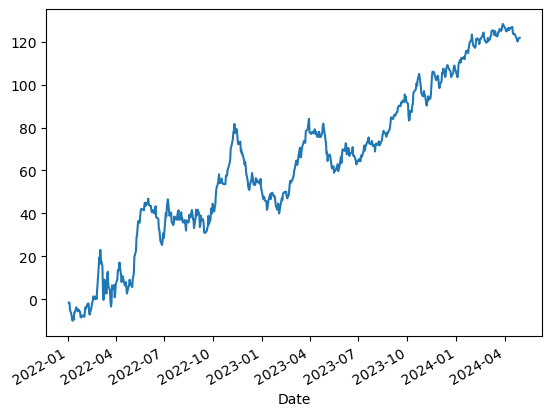

In [9]:
plt.show()
g['lag1'] = g['Retorno'].shift(-1)*100
g['alvo_bin'] = np.where(g['lag1'] > 0, 1, 0)   
g['retorno'] = np.where(g['mod_reg_bin'] == 1, g['lag1'], -g['lag1'])
#meta['retorno'] = np.where(meta['retorno'] <= -1, -1, meta['retorno'])
g['retorno_acumulado'] = g['retorno'].cumsum()
g['retorno_acumulado'].plot()



acerto = 0
erro = 0
for i in range(len(g)):
    if (g['mod_reg_bin'][i] == 1) & (g['alvo_bin'][i] == 1):
        acerto +=1
    elif (g['mod_reg_bin'][i] == 0) & (g['alvo_bin'][i] == 0):
        acerto +=1
    elif (g['mod_reg_bin'][i] == 1) & (g['alvo_bin'][i] == 0):
        erro +=1
    elif (g['mod_reg_bin'][i] == 0) & (g['alvo_bin'][i] == 1):
        erro +=1
print('retorno', g['retorno'].sum())
print('acerto', acerto)
print('erro', erro)
print('acuracia', acerto/(acerto+erro))
print('total de trades', acerto+erro)
print('total de dias' , len(g))
print('retorno acumulado em %', g['retorno_acumulado'][-3])
print('retorno medio do acerto',  g['retorno'].mean())
print('retorno medio do erro',  g['retorno'][g['retorno'] < 0].mean())
print('retorno medio do acerto',  g['retorno'][g['retorno'] > 0].mean())
print('stop loss recomendado de: -', g['lag1'].rolling(60).std().tail(2).values[0] )
if g['mod_reg_bin'].iloc[-1] == 1:
    print('Compre')
elif g['mod_reg_bin'].iloc[-1] == 0:
    print('Venda')
else:
    print('Fique de fora')

In [10]:
g

,Open,High,Low,Close,Retorno,RSL5,RSL5q,RSL20,delta,gain,...,COS_DIST3,COS_DIST3_cat,EUC_DIST3,EUC_DIST3_cat,mod_reg,mod_reg_bin,lag1,alvo_bin,retorno,retorno_acumulado
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,75.84,76.49,74.32,76.08,0.010224,-0.000841,3.0,0.043757,0.77,0.77,...,3.574764,4,1.203518,1,-0.000337,0,1.537855,1,-1.537855,-1.537855
2022-01-04,76.04,77.68,75.75,77.25,0.015379,0.011496,5.0,0.054824,1.17,1.17,...,3.453136,4,1.541352,2,-0.000855,0,0.000000,0,-0.000000,-1.537855
2022-01-05,77.21,78.61,76.56,77.25,0.000000,0.009989,4.0,0.051121,0.00,0.00,...,3.285378,3,1.294861,1,-0.000758,0,3.184466,1,-3.184466,-4.722321
2022-01-06,77.22,80.27,76.78,79.71,0.031845,0.033584,6.0,0.079599,2.46,2.46,...,2.852604,2,2.089154,2,0.001882,1,-1.041275,0,-1.041275,-5.763596
2022-01-07,79.64,80.50,78.55,78.88,-0.010413,0.013439,5.0,0.062550,-0.83,0.00,...,2.591455,0,0.000000,0,0.000817,1,-0.570487,0,-0.570487,-6.334082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,83.84,84.16,82.89,83.24,-0.007156,0.003448,3.0,-0.016918,-0.60,0.00,...,2.803338,1,1.050327,1,-0.000144,0,1.177319,1,-1.177319,120.257490
2024-04-25,83.27,84.26,82.44,84.22,0.011773,0.010923,4.0,-0.006652,0.98,0.98,...,3.211994,3,0.813049,1,0.000943,1,-0.166231,0,-0.166231,120.091259
2024-04-26,84.24,84.89,83.79,84.08,-0.001662,0.005790,4.0,-0.008707,-0.14,0.00,...,3.764381,4,0.000000,0,-0.004000,0,-1.225024,0,1.225024,121.316282
